<a href="https://colab.research.google.com/github/krgdev90/AnalyzeTheChat/blob/master/hello_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# https://github.com/tesseract-ocr/tesseract/wiki
!sudo apt install -y tesseract-ocr libtesseract-dev 
!tesseract --version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
tesseract 4.0.0-beta.1
 leptonica-1.75.3
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.2) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0

 Found AVX2
 Found AVX
 Found SSE


In [27]:
#For pdf2image
# ubuntu:
!sudo apt-get install -y poppler-utils 
# mac:
## !brew install poppler




Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [28]:
!pip install Pillow pytesseract opencv-python numpy pandas pdf2image
##setup reqd: https://github.com/Belval/pdf2image

In [29]:
# #upload from local
# from google.colab import files
# !dir #list files in current dir
# uploaded = files.upload()
# !dir

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
from PIL import Image
from pprint import pprint

In [31]:
filename = 'patient_report.pdf'

In [32]:
#convert pdf to image files
import pdf2image
#setup reqd: https://github.com/Belval/pdf2image

def pdf_to_img(pdf_file):
    return pdf2image.convert_from_path(pdf_file)

if '.pdf' in filename:
  pages = pdf_to_img(pdf_file=filename)
  # print(len(pages))
  f = filename.replace('.pdf','')
  for i, pag in enumerate(pages):
    #create a file for every page
      pag.save('{}_{}.jpg'.format(f, str(i + 1)))
!dir

aurebesh.jpg	      patient_report_2.jpg  patient_report_5.jpg
digits-task.jpg       patient_report_3.jpg  patient_report.pdf
patient_report_1.jpg  patient_report_4.jpg  sample_data


In [33]:
#pre-processing

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
      angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 


In [34]:
# filename = 'invoice-sample.jpg'
filename = 'patient_report_1.jpg'
image = cv2.imread(filename)

In [35]:
#pre-process
gray_img = get_grayscale(image)
thresh_img = thresholding(gray_img)
opening_img = opening(gray_img)
canny_img = canny(gray_img)

In [36]:
img = gray_img

Text(0.5, 1.0, 'hello')

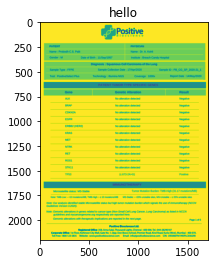

In [37]:
#plot
plt.imshow(img)
# plt.imshow(thresh)
plt.title('hello')

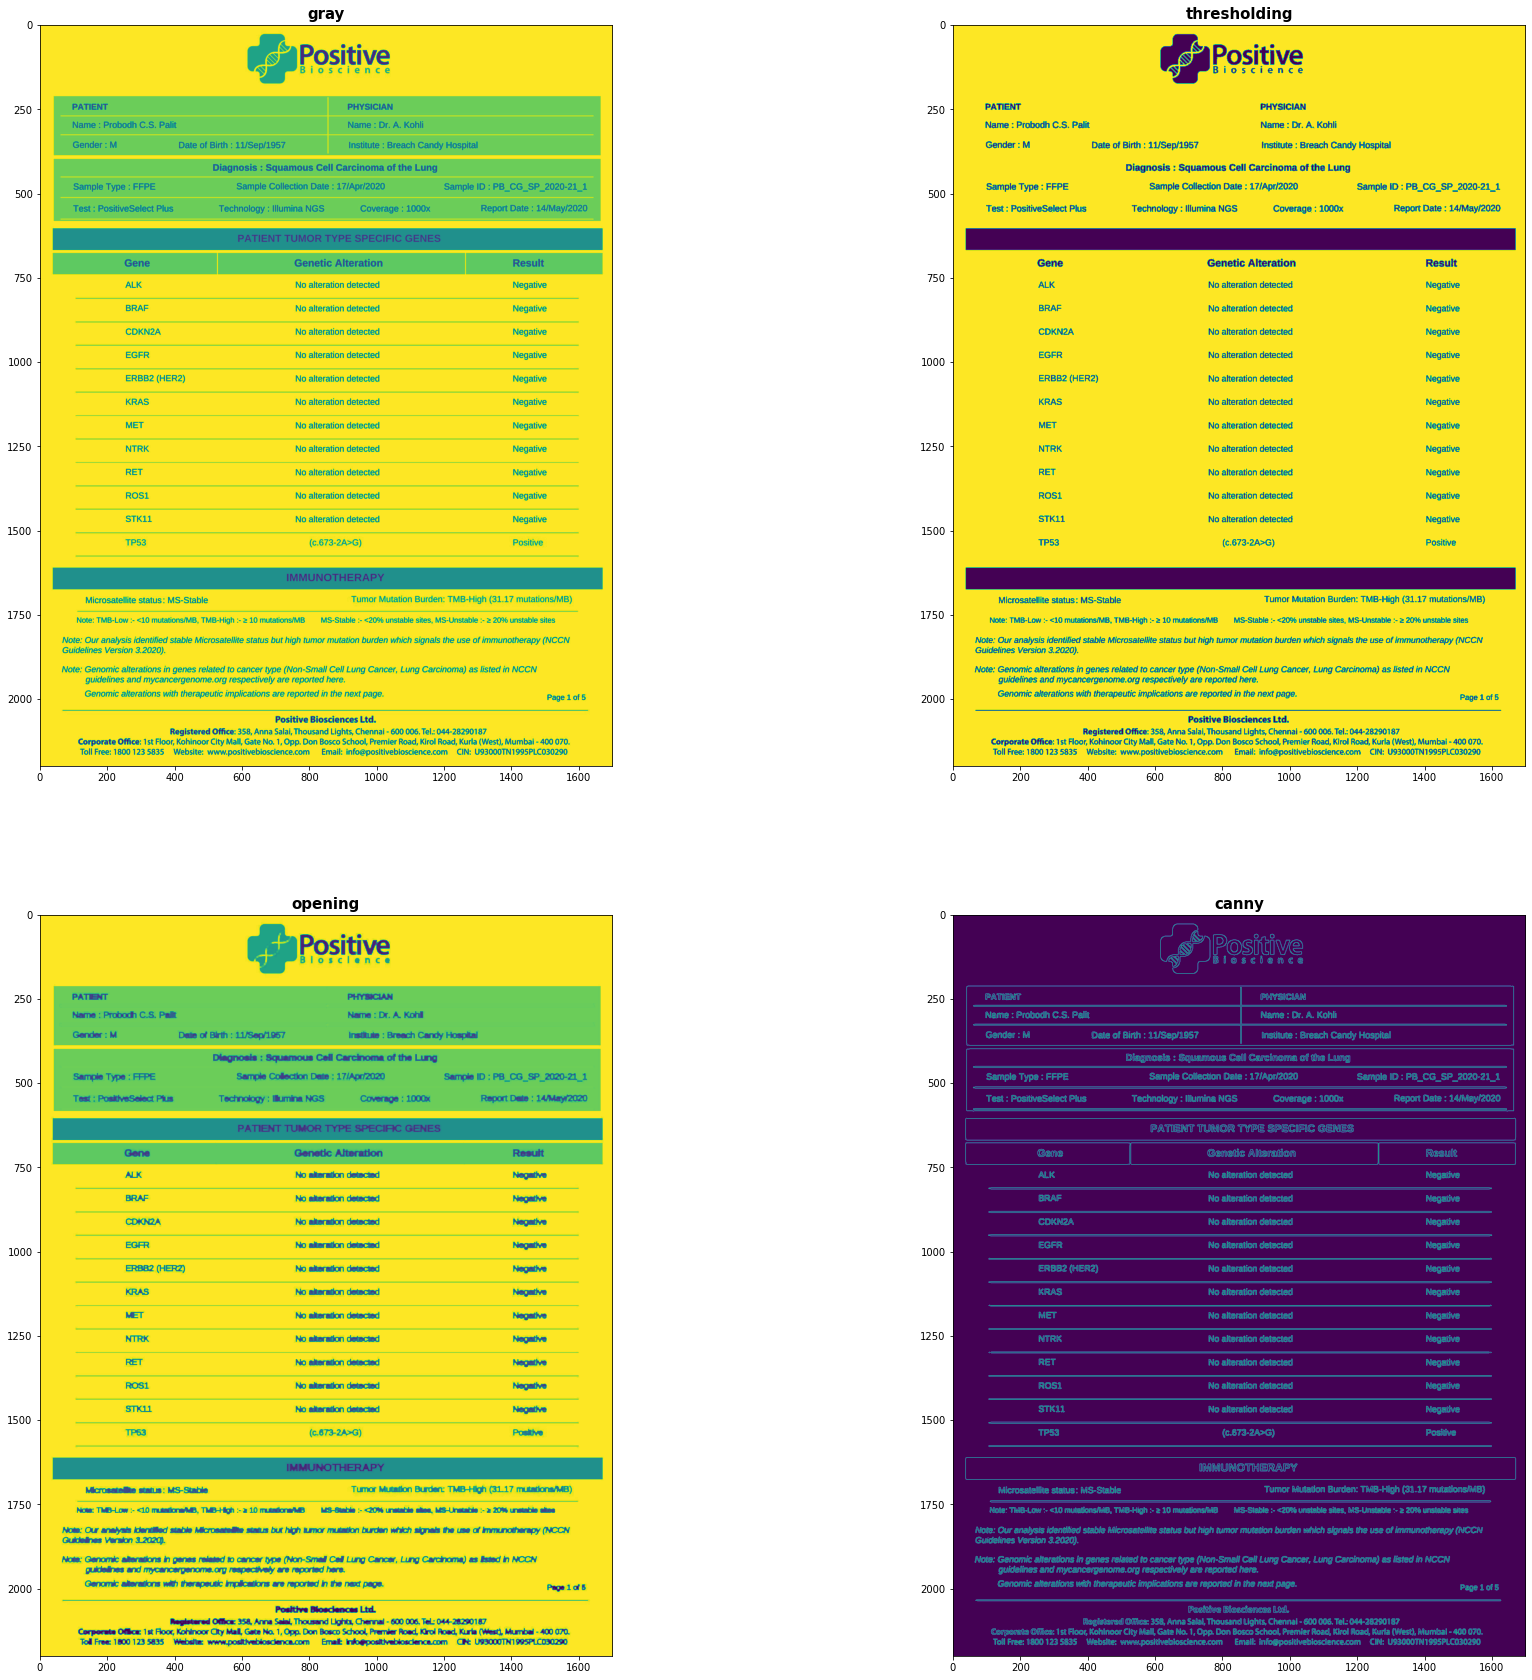

In [38]:
# plt.style.use('seaborn')
n_rows = 2
n_cols = 2
fig_raw_data, axes = plt.subplots(n_rows,n_cols,figsize=(30,30))
# axes.imshow(img)
axes[0,0].set_title("gray", fontsize=15,weight='semibold')
axes[0,0].imshow(gray_img)
#thresholding
axes[0,1].set_title("thresholding", fontsize=15,weight='semibold')
axes[0,1].imshow(thresh_img)
#
axes[1,0].set_title("opening", fontsize=15,weight='semibold')
axes[1,0].imshow(opening_img)
#
axes[1,1].set_title("canny", fontsize=15,weight='semibold')
axes[1,1].imshow(canny_img)

In [39]:
def get_text_from_img(img):
  # Adding custom options
  custom_config = r'--oem 3 --psm 6'
  return pytesseract.image_to_string(img, config=custom_config)

In [40]:
text = get_text_from_img(img)

In [41]:
text

"'&, [> e e\nS\nSs ositive\nSS Bioscience\nPATIENT PHYSICIAN\nName : Probodh C-S. Palit Name: Dr. A. Kohli\nGender : M Date of Birth : 11/Sep/1957 Institute : Breach Candy Hospital\nDiagnosis : Squamous Cell Carcinoma of the Lung\nSample Type : FFPE Sample Collection Date : 17/Apr/2020 Sample ID : PB_CG_SP_2020-21_1\nTest : PositiveSelect Plus Technology : Illumina NGS Coverage : 1000x Report Date : 14/May/2020\nGene Genetic Alteration Result\nALK No alteration detected Negative\nBRAF No alteration detected Negative\nCDKN2A No alteration detected Negative\nEGFR No alteration detected Negative\nERBB2 (HER2) No alteration detected Negative\nKRAS No alteration detected Negative\nMET No alteration detected Negative\nNTRK No alteration detected Negative\nRET No alteration detected Negative\nROS1 No alteration detected Negative\nSTK11 No alteration detected Negative\nTP53 (c.673-2A>G) Positive\nMicrosatellite status: MS-Stable Tumor Mutation Burden: TMB-High (31.17 mutations/MB)\nNote: TMB-L

In [42]:
# text.split('\n')
pprint(text.split('\n'))

["'&, [> e e",
 'S',
 'Ss ositive',
 'SS Bioscience',
 'PATIENT PHYSICIAN',
 'Name : Probodh C-S. Palit Name: Dr. A. Kohli',
 'Gender : M Date of Birth : 11/Sep/1957 Institute : Breach Candy Hospital',
 'Diagnosis : Squamous Cell Carcinoma of the Lung',
 'Sample Type : FFPE Sample Collection Date : 17/Apr/2020 Sample ID : '
 'PB_CG_SP_2020-21_1',
 'Test : PositiveSelect Plus Technology : Illumina NGS Coverage : 1000x Report '
 'Date : 14/May/2020',
 'Gene Genetic Alteration Result',
 'ALK No alteration detected Negative',
 'BRAF No alteration detected Negative',
 'CDKN2A No alteration detected Negative',
 'EGFR No alteration detected Negative',
 'ERBB2 (HER2) No alteration detected Negative',
 'KRAS No alteration detected Negative',
 'MET No alteration detected Negative',
 'NTRK No alteration detected Negative',
 'RET No alteration detected Negative',
 'ROS1 No alteration detected Negative',
 'STK11 No alteration detected Negative',
 'TP53 (c.673-2A>G) Positive',
 'Microsatellite statu

In [43]:
# Text template matching
import re
from pytesseract import Output

# img = cv2.imread('invoice-sample.jpg')
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())
keys

['level',
 'page_num',
 'block_num',
 'par_num',
 'line_num',
 'word_num',
 'left',
 'top',
 'width',
 'height',
 'conf',
 'text']

In [44]:
# date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'
pattern = 'ALK'
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
    	if re.match(pattern, d['text'][i]):
	        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
	        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
# DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions to crash; see https://github.com/jupyter/notebook/issues/3935.
# As a substitution, consider using : from google.colab.patches import cv2_imshow
# from google.colab.patches import cv2_imshow
# cv2.imshow( img)

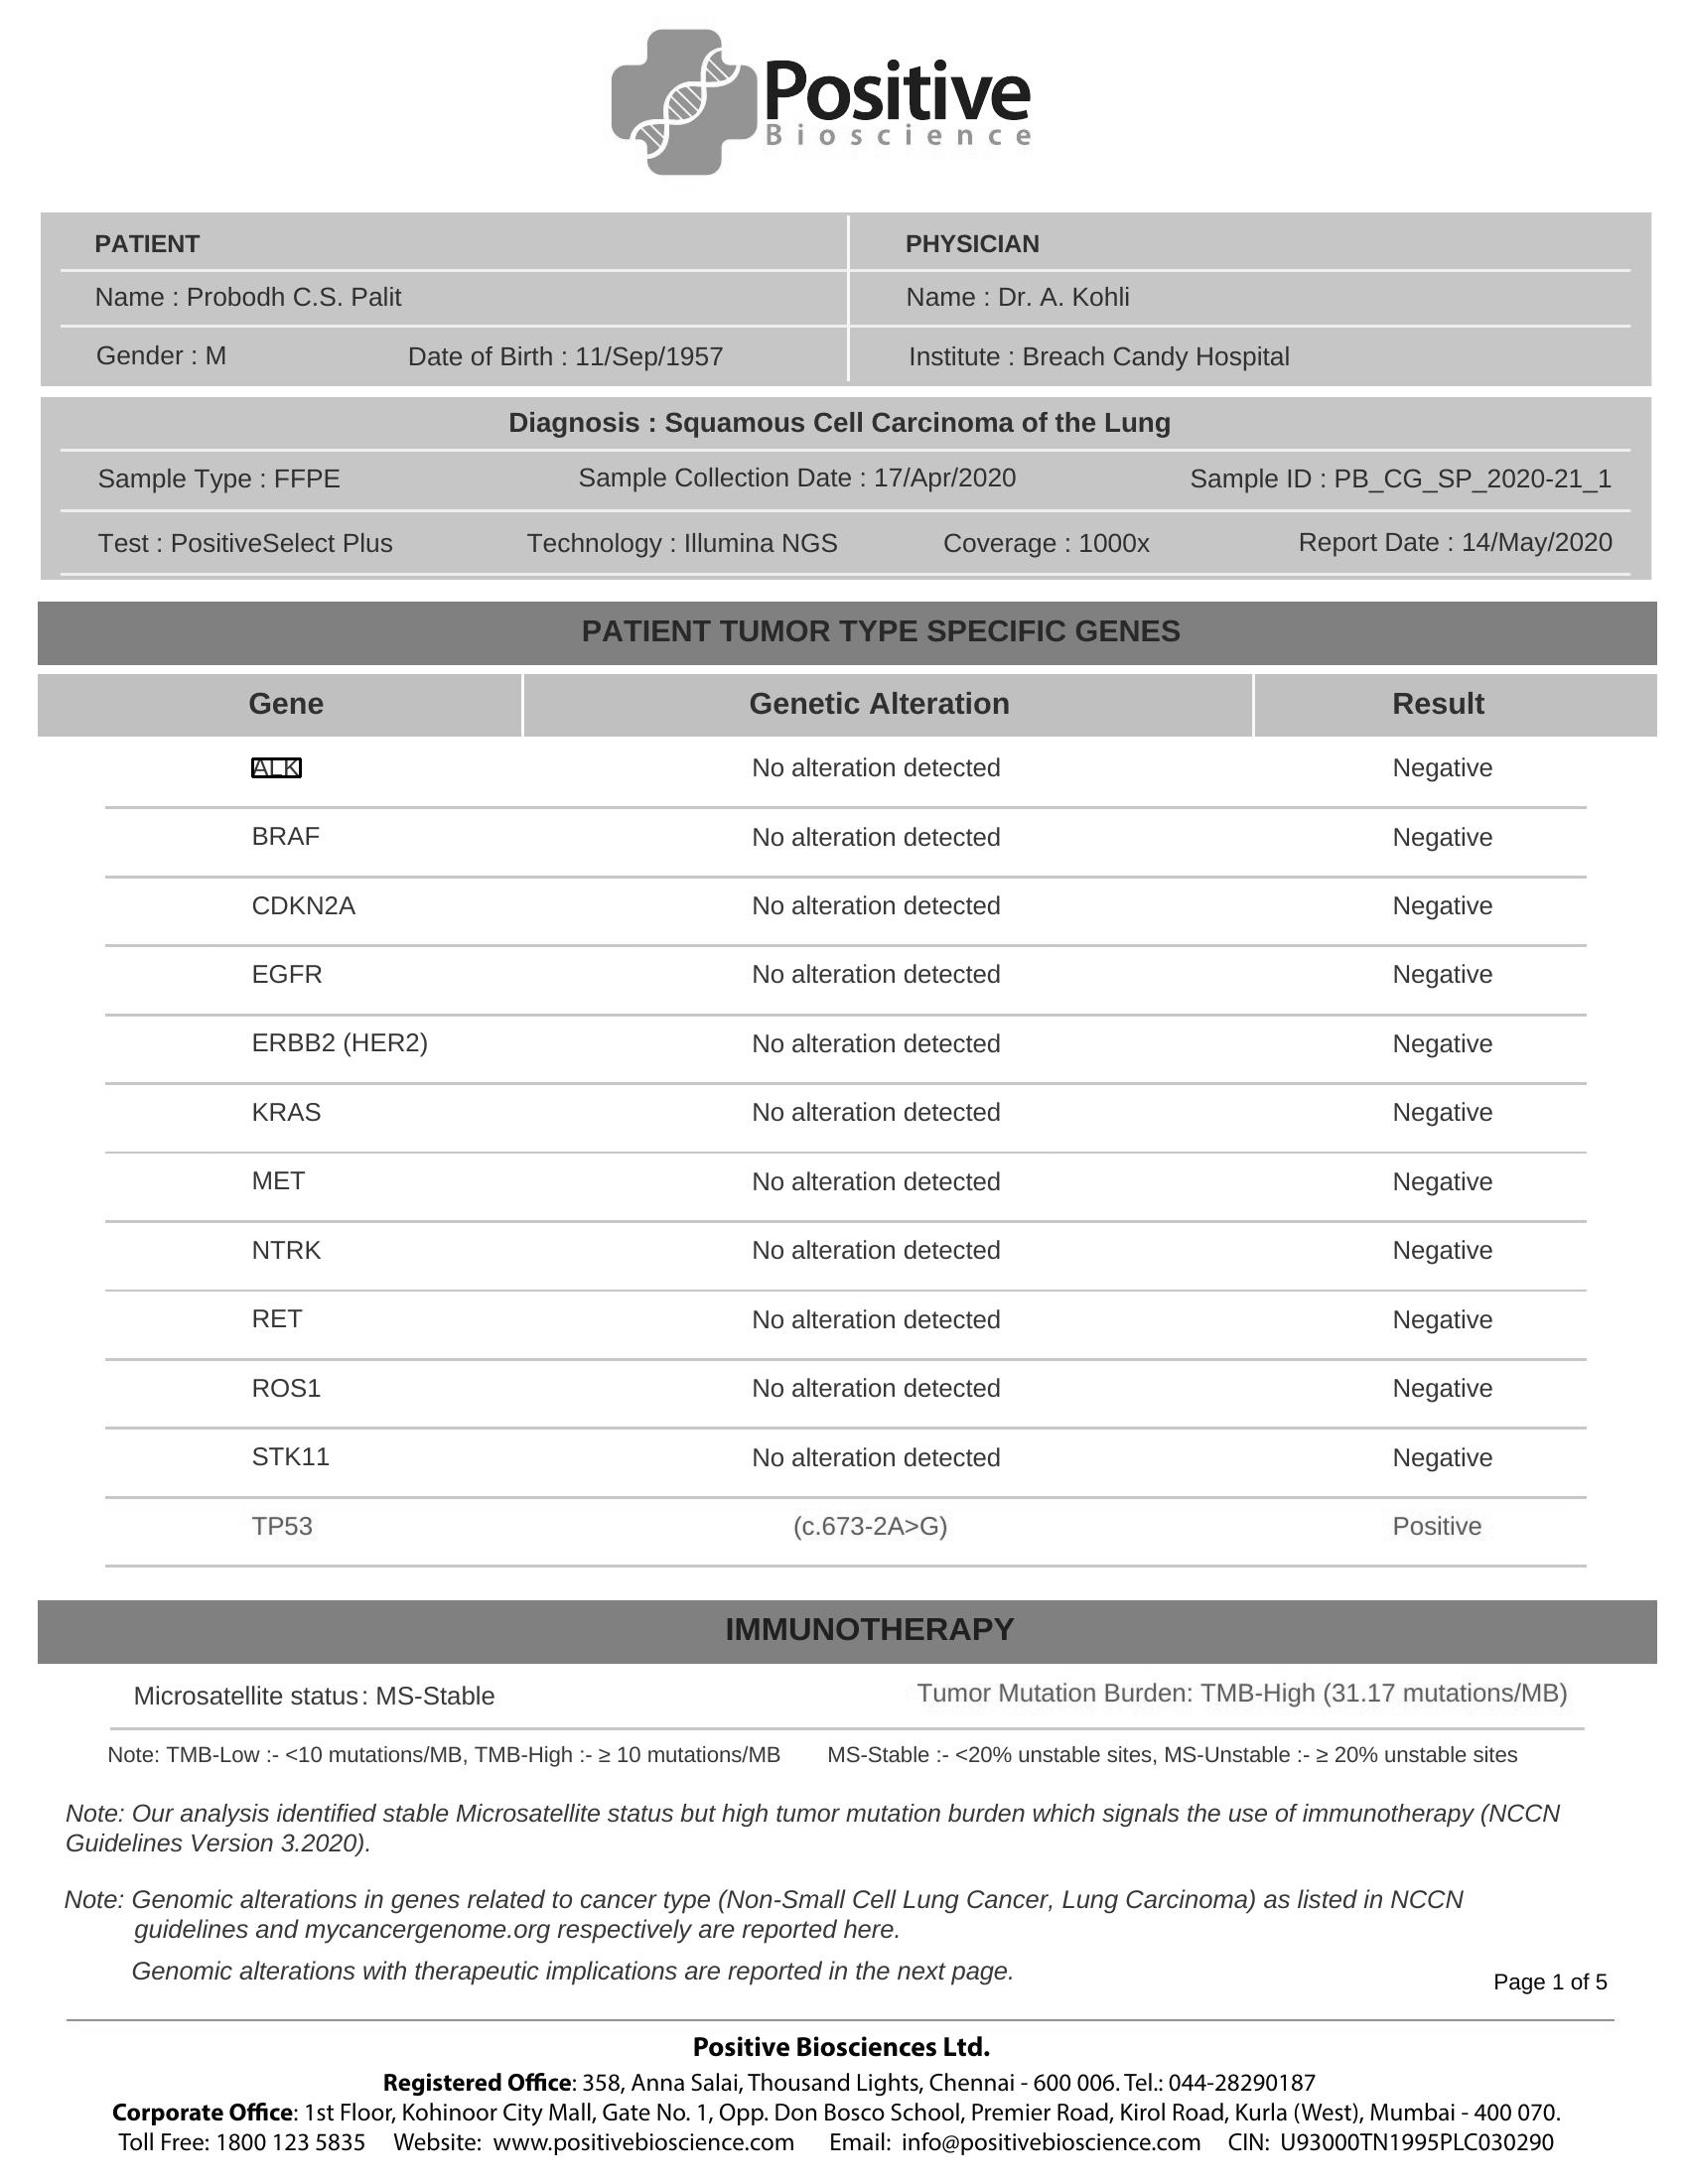

In [45]:
# DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions to crash; see https://github.com/jupyter/notebook/issues/3935.
# As a substitution, consider using : from google.colab.patches import cv2_imshow
# from google.colab.patches import cv2_imshow

from google.colab.patches import cv2_imshow
cv2_imshow( img)

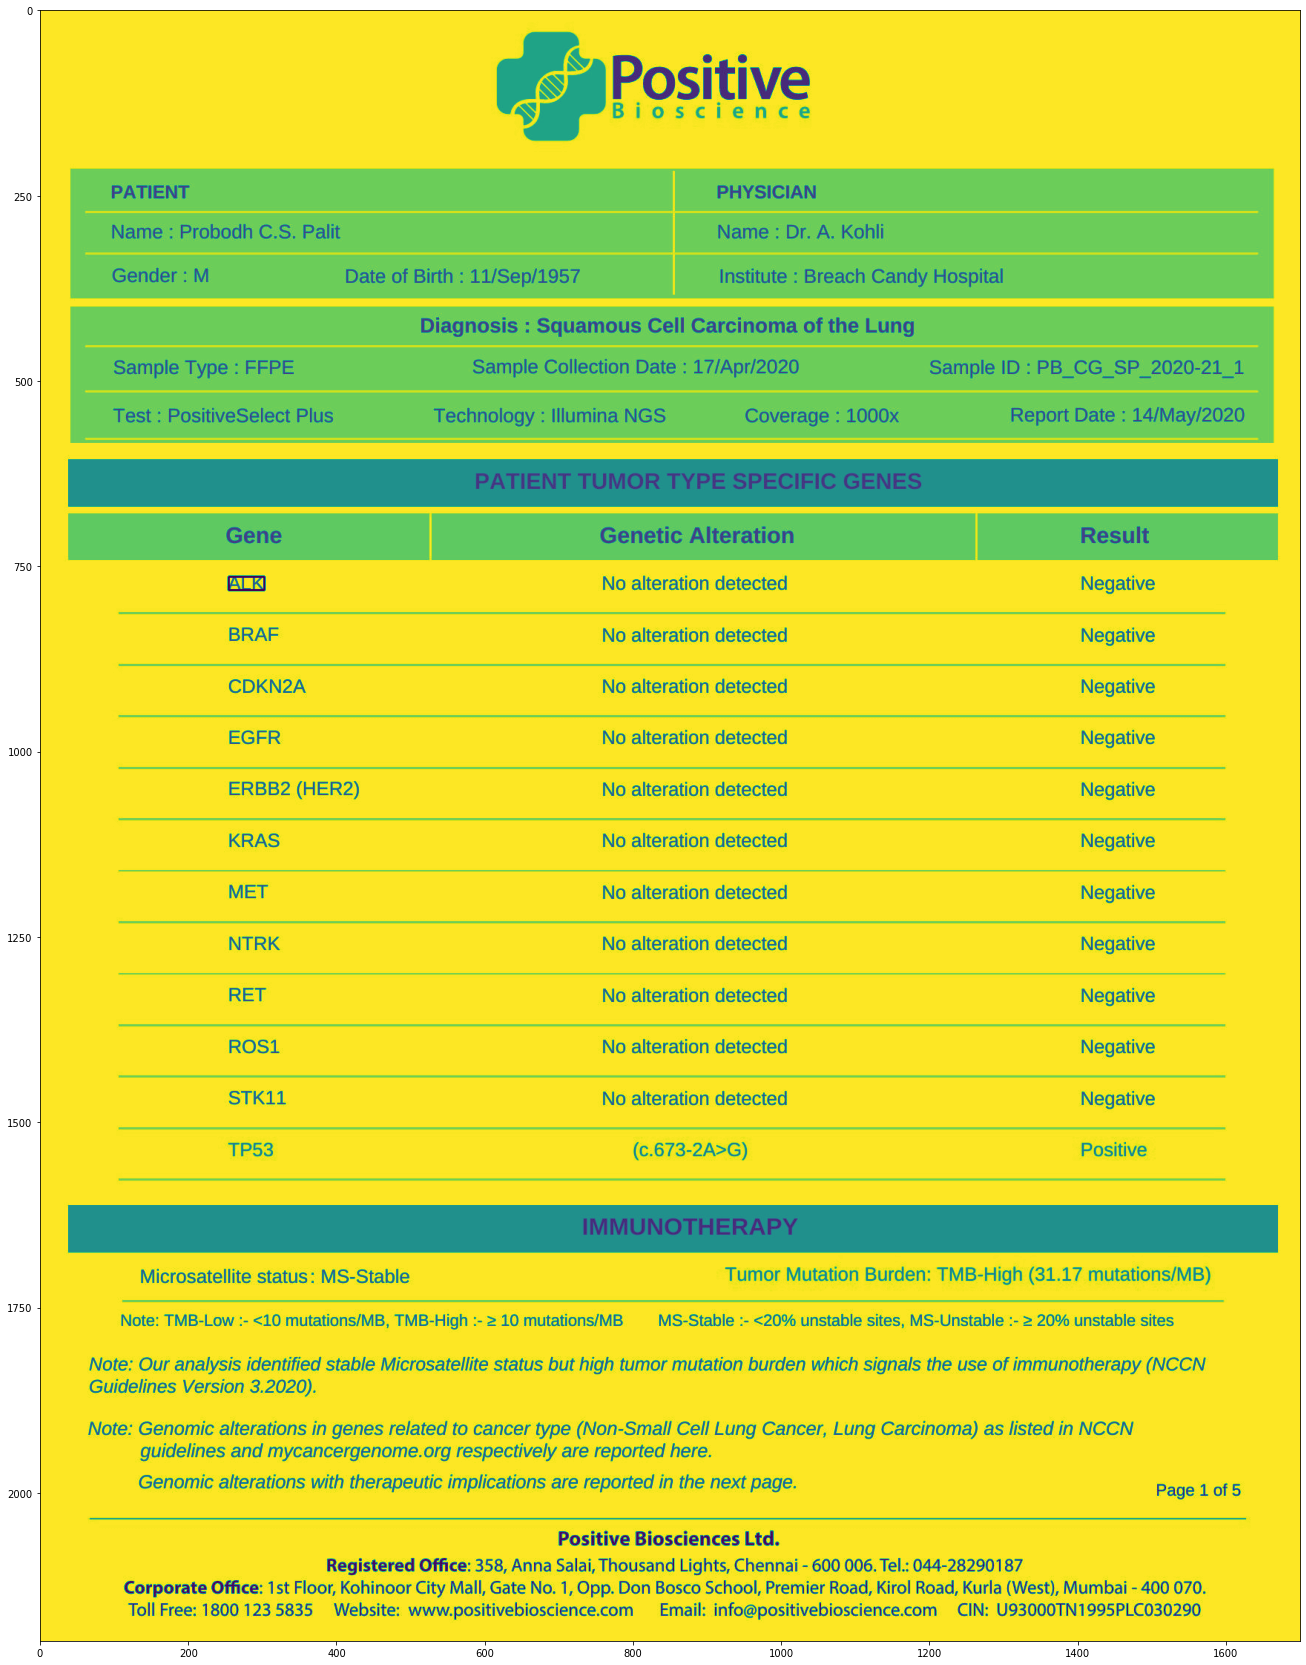

In [46]:
n_rows = 1
n_cols = 1
fig_raw_data, axes = plt.subplots(n_rows,n_cols,figsize=(30,30))
axes.imshow(img)

In [47]:
import spacy

In [48]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_core_sci_sm-0.2.5.tar.gz

In [53]:
import scispacy
import spacy

nlp = spacy.load("en_core_sci_sm")
# text = """
# Myeloid derived suppressor cells (MDSC) are immature 
# myeloid cells with immunosuppressive activity. 
# They accumulate in tumor-bearing mice and humans 
# with different types of cancer, including hepatocellular 
# carcinoma (HCC).
# """
doc = nlp(text)

pprint(list(doc.sents))

[',
 &, [> e e
S
Ss ositive
SS Bioscience
PATIENT PHYSICIAN
,
 Name :,
 Probodh C-S. Palit Name:,
 Dr. A. Kohli
Gender : M Date of Birth :,
 11/Sep/1957 Institute : Breach Candy Hospital
Diagnosis :,
 Squamous Cell Carcinoma of the Lung
Sample Type : FFPE Sample Collection Date : 17/Apr/2020 Sample ID : PB_CG_SP_2020-21_1
Test : PositiveSelect Plus Technology : Illumina NGS Coverage :,
 1000x Report Date :,
 14/May/2020
Gene Genetic Alteration Result
ALK No alteration detected Negative
BRAF No alteration detected Negative
CDKN2A No alteration detected Negative
EGFR No alteration detected Negative
ERBB2 (HER2) No alteration detected Negative
KRAS No alteration detected Negative
MET No alteration detected Negative
NTRK No alteration detected Negative
RET No alteration detected Negative
ROS1 No alteration detected Negative
STK11 No alteration detected Negative
TP53 (c.673-2A>G) Positive
Microsatellite status: MS-Stable Tumor Mutation Burden: TMB-High (31.17 mutations/MB)
Note: TMB-Low :- 

In [54]:
# pprint(doc.ents)
[(ent.text, ent.label_) for ent in doc.ents]

[('S', 'ENTITY'),
 ('Bioscience', 'ENTITY'),
 ('PATIENT', 'ENTITY'),
 ('PHYSICIAN', 'ENTITY'),
 ('Probodh C-S. Palit Name', 'ENTITY'),
 ('Dr. A. Kohli\nGender', 'ENTITY'),
 ('Birth', 'ENTITY'),
 ('Breach Candy Hospital', 'ENTITY'),
 ('Squamous Cell Carcinoma', 'ENTITY'),
 ('Lung\nSample Type', 'ENTITY'),
 ('FFPE', 'ENTITY'),
 ('Sample', 'ENTITY'),
 ('ID', 'ENTITY'),
 ('PB_CG_SP_2020', 'ENTITY'),
 ('21_1\nTest', 'ENTITY'),
 ('PositiveSelect Plus Technology', 'ENTITY'),
 ('Illumina', 'ENTITY'),
 ('NGS', 'ENTITY'),
 ('Coverage', 'ENTITY'),
 ('Genetic Alteration', 'ENTITY'),
 ('ALK', 'ENTITY'),
 ('detected', 'ENTITY'),
 ('Negative', 'ENTITY'),
 ('BRAF', 'ENTITY'),
 ('detected', 'ENTITY'),
 ('Negative', 'ENTITY'),
 ('CDKN2A', 'ENTITY'),
 ('detected', 'ENTITY'),
 ('Negative', 'ENTITY'),
 ('EGFR', 'ENTITY'),
 ('detected', 'ENTITY'),
 ('Negative', 'ENTITY'),
 ('ERBB2', 'ENTITY'),
 ('HER2', 'ENTITY'),
 ('alteration', 'ENTITY'),
 ('detected', 'ENTITY'),
 ('Negative', 'ENTITY'),
 ('KRAS', 'ENTITY